# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms,models
from PIL import Image
import helper
from collections import OrderedDict
from torch.autograd import Variable
import time
from random import randint
import os

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transfoms:a dictionnary with train_transform, valid_transform and test_transform as keys
data_transforms = {"train_transform": transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
                  "valid_transform": transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                [0.229, 0.224, 0.225])]),
                        "test_transform": transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
                                                               }

In [5]:
# TODO: Load the datasets with ImageFolder
#image_datasets:a dictionnary with train_set, test_set and valid_set as keys
image_datasets = { "train_set" : datasets.ImageFolder(train_dir, transform=data_transforms["train_transform"]),
                   "test_set" : datasets.ImageFolder(test_dir ,data_transforms[ "valid_transform"]),                 
                  "valid_set": datasets.ImageFolder(valid_dir, data_transforms["test_transform"])} 

In [6]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
#image_datasets:a dictionnary with train_loader, test_loader and valid_loader as keys
dataloaders = { "train_loader" : torch.utils.data.DataLoader(image_datasets["train_set"], batch_size=64, shuffle=True),
                   "test_loader" : torch.utils.data.DataLoader(image_datasets[ "test_set"], batch_size=32, shuffle=True),
                  "valid_loader": torch.utils.data.DataLoader(image_datasets[ "valid_set"], batch_size=32, shuffle=True)}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# TODO: Build and train your network

## 1. VISUALIZE THE TRAIN, TEST AND VALIDATION DATASETS

### 1a. VISUALIZATION OF TRAINING DATASETS

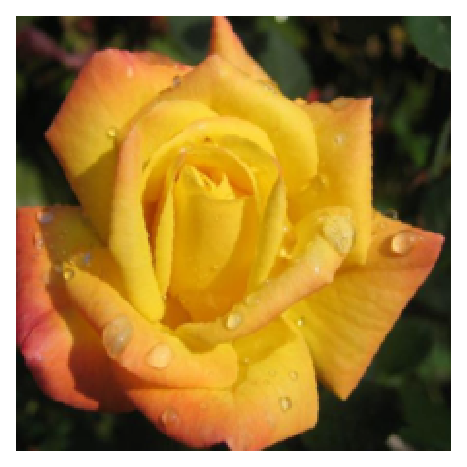

In [9]:
# Check the train loader images
images, labels = next(iter(dataloaders ["train_loader"]))
#set a random number between 0 and length of train set immage
train_index = randint(0, len(next(iter(dataloaders ["train_loader"]))))
#plot the random train images selected
helper.imshow(images[train_index], normalize=True)

### 1b. VISUALIZATION OF TEST DATASETS

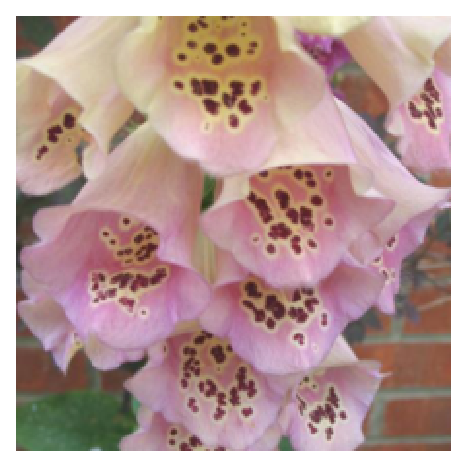

In [10]:
# Check the test loader images
images, labels = next(iter(dataloaders ["test_loader"]))
#set a random number between 0 and length of test set images
test_index = randint(0, len(next(iter(dataloaders ["test_loader"]))))
#plot the random test images selected
helper.imshow(images[test_index], normalize=True)

### 1c. VISUALIZATION OF VALIDATION DATASETS

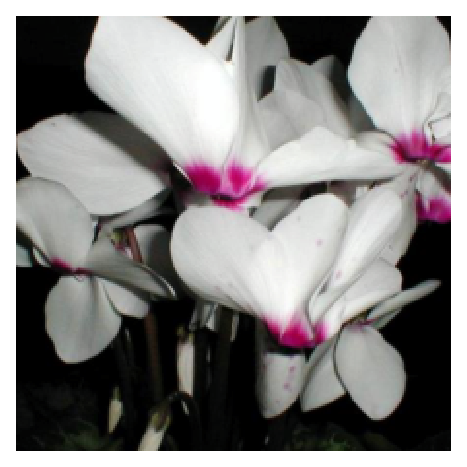

In [11]:
# Check the test loader images
images, labels = next(iter(dataloaders ["valid_loader"]))
#set a random number between 0 and length of test set images
valid_index = randint(0, len(next(iter(dataloaders ["valid_loader"]))))
#plot the random test images selected
helper.imshow(images[test_index], normalize=True)

In [12]:
print(dir(models))

['AlexNet', 'DenseNet', 'Inception3', 'ResNet', 'SqueezeNet', 'VGG', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception', 'inception_v3', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


## 2. SET THE NETWORK ARCHITECTURE

In [15]:
#Setup the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
archs = {"vgg11": 25088, "vgg13": 25088, "vgg16": 25088, "vgg19": 25088, "densenet121" : 1024,"densenet161":2208, 
         "densenet201" : 1920,\
         "alexnet" : 9216, "inception_v3":2048 ,"resnet101":2048 ,"squeezenet1_0":1000 ,"resnet34":512}

In [25]:
#Define the network architecture
def choose_model(arch = "vgg11", input_size=1024,  output_size = 102, dropout= 0.2, hidden_units = [100,90,80],lr = 0.001,epochs = 12):
    if arch == "vgg11":
        model = models.vgg11(pretrained=True)
    if arch == "vgg13":
        model = models.vgg13(pretrained=True)
    elif arch == "vgg16":
        model = models.vgg16(pretrained = True)
        
    elif arch == "vgg19":
        model = models.vgg19(pretrained = True)    
    elif arch == "densenet121":
        model = models.densenet121(pretrained=True)
    elif arch == "densenet161":
        model = models.densenet161(pretrained=True)
        
        
    elif arch == "densenet201":
        model = models.densenet201(pretrained = True)
    elif arch == "alexnet":
        model = models.alexnet(pretrained = True)
    elif arch == "inception_v3":
        model = models.inception_v3(pretrained=True)
        
    elif arch == "resnet101":
        model = models.resnet101(pretrained = True)
    elif arch == "squeezenet1_0":
        model = models.squeezenet1_0(pretrained = True)
    elif arch == "resnet34":
        model = models.resnet34(pretrained=True)    
    else:
        print("The choosen model architecture don't match {} . Plase choose a vilid one".format(arch))
        
    for param in model.parameters():
        param.requires_grad = False
        input_size = archs[arch]
        
        classifier = nn.Sequential(
                                  nn.Linear(input_size, hidden_units[0]),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(hidden_units[0], hidden_units[1]),
                                  nn.ReLU(),
                                  nn.Linear(hidden_units[1], hidden_units[2]),
                                  nn.ReLU(),
                                  nn.Linear(hidden_units[2], output_size),
                                  nn.LogSoftmax(dim=1)
                                  )
        
        model.classifier = classifier
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.classifier.parameters(), lr)
        model.to(device)
        return model , optimizer , criterion 
    

#model,optimizer,criterion = choose_model("vgg11")#
#model,optimizer,criterion = choose_model("vgg13")
#model,optimizer,criterion = choose_model("vgg16" )#
#model,optimizer,criterion = choose_model("vgg19") 

model,optimizer,criterion = choose_model("densenet121")#
#model,optimizer,criterion = choose_model("densenet161")
#model,optimizer,criterion = choose_model("densenet201")
#model,optimizer,criterion = choose_model("alexnet")#

#model,optimizer,criterion = choose_model(""inception_v3")   
#model,optimizer,criterion = choose_model("resnet101")#
#model,optimizer,criterion = choose_model("squeezenet1_0")
#model,optimizer,criterion = choose_model("resnet34" )#

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 81030465.43it/s]


In [26]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

## 3. TRAIN THE NETWORK 

We train the network on differents architecture to choose the best one VGG16, DENSENET121, ALEXNET

In [16]:
def validation (model, dataloaders, criterion):
    accuracy = 0
    valid_loss = 0
    for inputs, labels in dataloaders["valid_loader"]:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        valid_loss += batch_loss.item()
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        return valid_loss, accuracy                    

In [17]:
epochs = 9
#epochs = 1
steps = 0
train_losses, valid_losses = [], []
#running_loss = 0
print_every = 30
for epoch in range(epochs):
    # model in training mode, dropout is on
    model.train()
    running_loss = 0
    for inputs, labels in dataloaders["train_loader"]:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            #Model in inference modee , dropout is off
            model.eval()
            #Turn off gradients for validation to speed up inference
            with torch.no_grad():
                
                valid_loss , accuracy = validation (model, dataloaders, criterion)

                    
            train_losses.append(running_loss/len(dataloaders["train_loader"]))
            valid_losses.append(valid_loss/len(dataloaders["valid_loader"]))
            
            print("Epoch: {}/{}... ".format(epoch+1, epochs),
                  "Loss: {:.3f}".format(running_loss/print_every),
                  "Validation Lost {:.3f}".format(valid_loss/len(dataloaders["valid_loader"])),
                   "Accuracy: {:.3f}".format(accuracy/len(dataloaders["valid_loader"]))
                  )
            running_loss = 0
            # Make sure dropout and grads are on for training
            #model.train()

Epoch: 1/9...  Loss: 4.565 Validation Lost 0.172 Accuracy: 0.001
Epoch: 1/9...  Loss: 4.334 Validation Lost 0.162 Accuracy: 0.002
Epoch: 1/9...  Loss: 3.839 Validation Lost 0.132 Accuracy: 0.010
Epoch: 2/9...  Loss: 1.829 Validation Lost 0.112 Accuracy: 0.016
Epoch: 2/9...  Loss: 2.728 Validation Lost 0.092 Accuracy: 0.012
Epoch: 2/9...  Loss: 2.335 Validation Lost 0.083 Accuracy: 0.016
Epoch: 3/9...  Loss: 0.326 Validation Lost 0.072 Accuracy: 0.019
Epoch: 3/9...  Loss: 1.885 Validation Lost 0.067 Accuracy: 0.019
Epoch: 3/9...  Loss: 1.767 Validation Lost 0.067 Accuracy: 0.023
Epoch: 3/9...  Loss: 1.619 Validation Lost 0.051 Accuracy: 0.026
Epoch: 4/9...  Loss: 1.409 Validation Lost 0.057 Accuracy: 0.023
Epoch: 4/9...  Loss: 1.482 Validation Lost 0.042 Accuracy: 0.030
Epoch: 4/9...  Loss: 1.395 Validation Lost 0.052 Accuracy: 0.023
Epoch: 5/9...  Loss: 0.471 Validation Lost 0.050 Accuracy: 0.024
Epoch: 5/9...  Loss: 1.292 Validation Lost 0.042 Accuracy: 0.030
Epoch: 5/9...  Loss: 1.18

## 5. PLOT THE LOSSES TO CHECK FOR OVER/UNDERFITTING

#### 5a. PLOT LOSSES FUNTION FOR ALEXNET  NETWORK

We choose alexnet architecture because its give us good accuracy  and it is faster to train

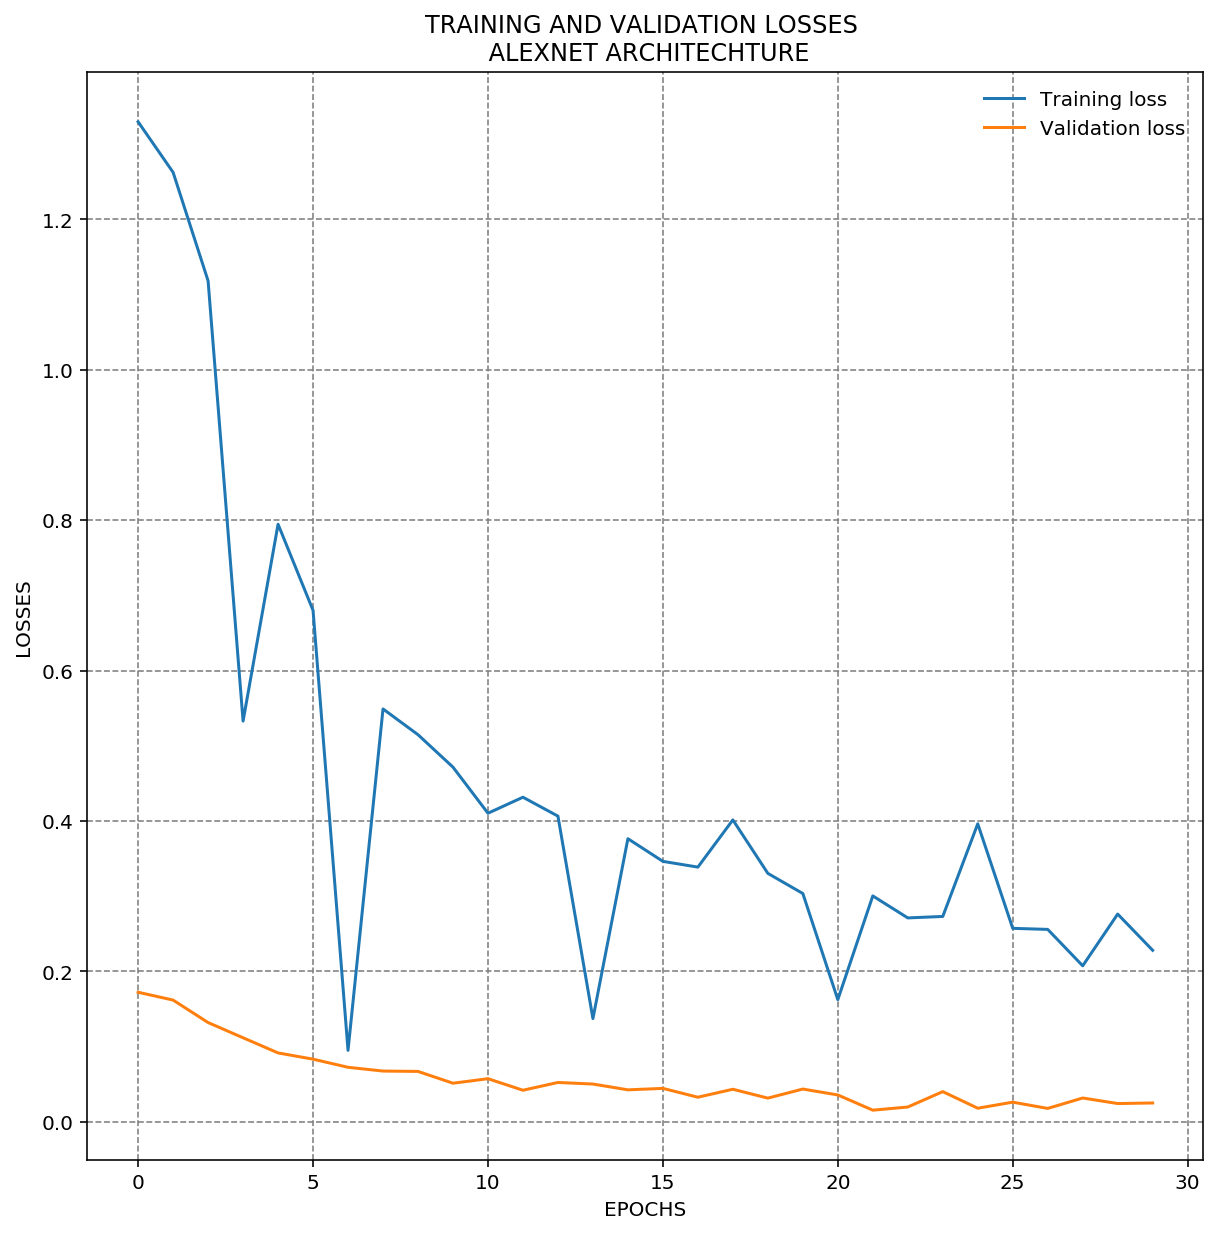

In [18]:
#Plot the loss for alexnet network
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(train_losses, label='Training loss')
ax.plot(valid_losses, label='Validation loss')
ax.legend(frameon=False)
ax.set(xlabel="EPOCHS",
       ylabel="LOSSES",
       title="TRAINING AND VALIDATION LOSSES \n ALEXNET ARCHITECHTURE")
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
#plt.show()
plt.savefig("alexnet_losses.png")

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [21]:
# TODO: Do validation on the test set
def accuracy_on_test_data(test_data):
    corrects = 0
    totals = 0
    with torch.no_grad():
        if torch.cuda.is_available():
            print("Using cuda ")
        else:
            print("Using CPU")

        for inputs, labels in test_data:
            inputs = inputs.to(device)
            labels = labels.to(device)        

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            totals += labels.size(0)
            corrects += (predicted == labels).sum().item()

        print('The accuracy of the neural network on test images is : %d %%' % (100 * corrects / totals))

In [22]:
accuracy_on_test_data(dataloaders["test_loader"])

Using cuda 
The accuracy of the neural network on test images is : 81 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [23]:
# TODO: Save the checkpoint 

In [24]:
model.class_to_idx = image_datasets ["train_set"].class_to_idx

In [25]:
model.to(device)
checkpoint = {
              'arch': 'densenet121',
              'input_size':  1024,
              'output_size': 102,
              'dropout': 0.2,
              'epochs' : 9,
              'lr': 0.001,
              'hidden_units': [100,90,80],
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx, 
              'optimizer_state_dict': optimizer.state_dict(),
            }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [26]:
# TODO: Write a function that loads a checkpoint and rebuilds the model


In [17]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model, _ ,_ = choose_model(
                             checkpoint['arch'],
                             checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['dropout'],
                             checkpoint['hidden_units'],
                             checkpoint['lr'],
                             checkpoint['epochs'],
                             
                            
                            )
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()
    #model.train()
    return model

In [27]:
model = load_checkpoint('checkpoint.pth')
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [106]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_loader = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor()])
    
    pil_image = Image.open(image)
    pil_image = img_loader(pil_image).float()
    
    np_image = np.array(pil_image)    
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std    
    np_image = np.transpose(np_image, (2, 0, 1))
    img_tensor = torch.from_numpy(np_image)
            
    return  img_tensor

In [107]:
import os

input_folder  =  data_dir + '/test' + '/60/'

input_file  = 'image_03026.jpg'

sample_img  = os.path.join(input_folder, input_file)

sample_img  = process_image(sample_img)

print(sample_img.shape)


torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [108]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

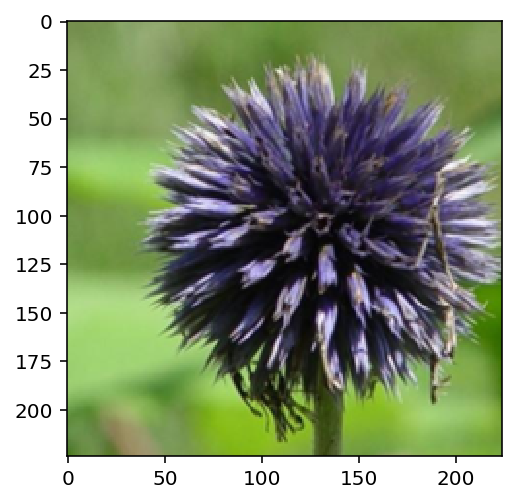

In [109]:
sample_img = (data_dir + '/test' + '/10/' + 'image_07104.jpg')
processed_img  =  process_image(sample_img)

_= imshow(processed_img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [110]:
''' Predict the class (or classes) of an image using a trained deep learning model.
'''
#model.class_to_idx =train_data.class_to_idx
#model.class_to_idx = image_datasets['train_set'].class_to_idx
def predict(image_path, model, topk):   
    #model.to(device)
    img_tensor = process_image(image_path)
    img_tensor =  img_tensor.unsqueeze_(0)
    img_tensor =  img_tensor.float()
    
    with torch.no_grad():
        output = model.forward(img_tensor.to(device))
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)
    
    
    # TODO: Implement the code to predict the class from an image file

In [111]:
probabilities = predict(sample_img, model, 5)
print(probabilities) 

(tensor(1.00000e-02 *
       [[ 1.1898,  1.1178,  1.1114,  1.1041,  1.0901]]), tensor([[ 44,  72,  48,  43,  16]]))


In [119]:
import os

input_folder  =  data_dir + '/test/' + '/10/'



input_file  = 'image_07104.jpg'



sample_img  = os.path.join(input_folder, input_file)

sample_img  = process_image(sample_img)

print(sample_img.shape)


torch.Size([3, 224, 224])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [136]:
def check_sanity(img_path):
    fig, axes = plt.subplots(2,1)
    
    image = mpimg.imread(img_path)
    #image = process_image(img_path)
    
    index = 1
    
    axes[0].imshow(image)
    
    axes[0].set_title(cat_to_name[str(index)])
    axes[0].axis('off')

    
    probabilities = predict(img_path, model, 5)
    
    prob = np.array(probabilities[0][0])

    
    classes = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    y = np.arange(len(classes))
    
    axes[1].barh(y, prob, align='center', color='blue')
    
    axes[1].set_yticks(y)
    
    axes[1].set_yticklabels(classes)
    
    axes[1].yaxis.grid(color='gray', linestyle='dashed')
    
    axes[1].xaxis.grid(color='gray', linestyle='dashed')
    axes[1].set(xlabel="PROBABILITY",
       ylabel="NAME",
       title="TOP 5 PREDICTED CLASSES ".lower()
    )
    axes[1].invert_yaxis()  # labels read top-to-bottom

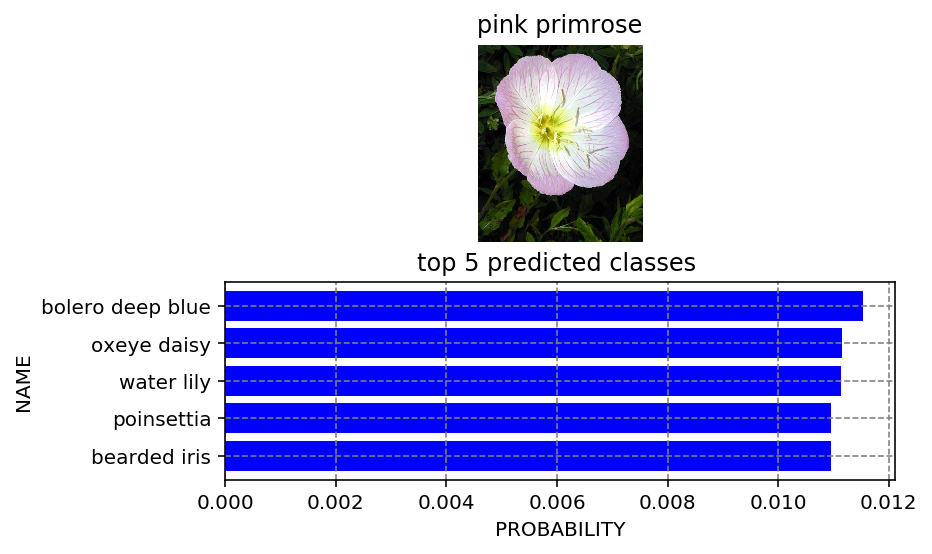

In [137]:
input_folder  =  data_dir + '/test/' + '/1/'

input_file  = 'image_06743.jpg'

sample_img  = os.path.join(input_folder, input_file)

check_sanity(sample_img)